In [1]:
# use gpd_2023 environment

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#import seaborn as sns
import pickle
#import torch

import gc

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss

# prob not using here
import pandas as pd
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Configure Matplotlib to use LaTeX and Computer Modern
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
})

In [2]:
local_dir_gen = '/home/simon/Documents/scripts/conflictNet/data/generated'
local_dir_pro = '/home/simon/Documents/scripts/conflictNet/data/processed'
timelaps_dir = '/home/simon/Documents/scripts/conflictNet/reports/timelapse/feature'

test_months = 48
n_features = 3

with open(f'{local_dir_gen}/posterior_dict_48_calib.pkl', 'rb') as file:
    posterior_dict = pickle.load(file)

with open(f'{local_dir_gen}/test_vol_48_calib.pkl', 'rb') as file:
    test_vol = pickle.load(file)


with open(f'{local_dir_pro}/viewser_monthly_vol_calib_sbnsos.pkl', 'rb') as file: # /viewser_monthly_vol_test_sbnsos.pkl
    views_vol = pickle.load(file)


In [3]:
new_shape = (1,) + views_vol.shape
views_vol.reshape(new_shape).shape

(1, 324, 180, 180, 8)

In [4]:
def discard_ME_cells(views_vol, un_masked_matrix, feature, month, test_months):

    # Hard coded...
    # For comparison with views 2020 where middle east is not included

    # 0 is ocean
    # You could load in the views replication data and get the c_id for only africa from there... More kosher
    middle_east_c_id = [
        0.0, 129.0, 130.0, 131.0, 128.0, 132.0, 133.0, 136.0, 55.0, 60.0, 62.0, 89.0,
        218.0, 92.0, 220.0, 94.0, 93.0, 96.0, 119.0, 122.0, 124.0, 125.0, 126.0, 127.0
    ]

    #middle_east_c_id = [0.0] # for debugging

    # Values to mask (0 and 1 in this example)
    values_to_mask = np.array(middle_east_c_id)

    #for point estimates
    if un_masked_matrix.ndim == 4:

        # Create a mask for the specified values
        mask = np.isin(views_vol[-test_months, :, :, 4], values_to_mask)
        # Mask the array using the created mask
        masked_matrix = np.ma.masked_where(mask, un_masked_matrix[month, feature, :, :]) # [month, feature, :, :] is for the feature, i.e. type of violence

    # for posterior samples
    else:
        mask = np.isin(views_vol[-test_months, :, :, 4], values_to_mask)
        mask = np.broadcast_to(mask[np.newaxis, :, :], un_masked_matrix[:, month, feature, :, :].shape)

        # Mask the array using the created mask
        masked_matrix = np.ma.masked_where(mask, un_masked_matrix[:, month, feature, :, :]) # [month, feature, :, :] is for the feature, i.e. type of violence

    # Get the 1D vector with masked-out values discarded
    #vector = masked_matrix.compressed()

    return masked_matrix #vector

# masked_matrix = discard_ME_cells(mean_class_pred, 0)


In [5]:
def calculate_metrics(i, j, test_months, y_pred_array, y_class_pred_array, out_of_sample_vol, metric_dict):

    y_score_masked_matrix = discard_ME_cells(views_vol, y_pred_array, j, i, test_months)
    y_score = y_score_masked_matrix.compressed()

    y_score_prob_masked_matrix = discard_ME_cells(views_vol, y_class_pred_array, j, i, test_months)
    y_score_prob = y_score_prob_masked_matrix.compressed()

    metric_dict = {"monthly/out_sample_month": i}

    y_true_masked_matrix = discard_ME_cells(views_vol, out_of_sample_vol.squeeze(), j, i, test_months)
    y_true = y_true_masked_matrix.compressed()
    y_true_binary = (y_true > 0) * 1

    mse = mean_squared_error(y_true, y_score)
    ap = average_precision_score(y_true_binary, y_score_prob)
    auc = roc_auc_score(y_true_binary, y_score_prob)
    brier = brier_score_loss(y_true_binary, y_score_prob)

    metric_dict[f"monthly/mean_squared_error{j}"] = mse
    metric_dict[f"monthly/average_precision_score{j}"] = ap
    metric_dict[f"monthly/roc_auc_score{j}"] = auc
    metric_dict[f"monthly/brier_score_loss{j}"] = brier

    return metric_dict

In [6]:
def calculate_metrics_sample(i, j, test_months, posterior_dict, metric_dict):

    y_pred = np.array(posterior_dict['posterior_list'])
    y_pred_class = np.array(posterior_dict['posterior_list_class'])
    y_true = posterior_dict['out_of_sample_vol']
    y_true_stacked = np.repeat(y_true, 128, axis=0)
    y_true_binary_stacked = (y_true_stacked > 0) * 1

    y_pred_masked = discard_ME_cells(views_vol, y_pred, j, i, test_months)
    y_pred_class_masked = discard_ME_cells(views_vol, y_pred_class, j, i, test_months)

    y_true_masked = discard_ME_cells(views_vol, y_true_stacked, j, i, test_months)
    y_true_binary_masked = discard_ME_cells(views_vol, y_true_binary_stacked, j, i, test_months)

    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []

    for k in range(y_pred_masked.shape[0]):
        mse_list.append(mean_squared_error(y_true_masked[k].compressed(), y_pred_masked[k].compressed()))
        ap_list.append(average_precision_score(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
        auc_list.append(roc_auc_score(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
        brier_list.append(brier_score_loss(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
    

    metric_dict[f"monthly/mean_squared_error_std{j}"] = np.array(mse_list).std()
    metric_dict[f"monthly/average_precision_score_std{j}"] = np.array(ap_list).std()
    metric_dict[f"monthly/roc_auc_score{j}_std"] = np.array(auc_list).std() 
    metric_dict[f"monthly/brier_score_loss{j}_std"] = np.array(brier_list).std()    

    return metric_dict


In [7]:

def make_df(posterior_dict, n_features, test_months):

    posterior_list = posterior_dict['posterior_list']
    posterior_list_class = posterior_dict['posterior_list_class']
    out_of_sample_vol = posterior_dict['out_of_sample_vol']

    # mean_class_pred = np.array(posterior_list_class[test_month]).mean(axis=0)
    # mean_pred = np.array(posterior_list[test_month]).mean(axis=0)

    # Get mean each month - much fater to do this outside the loop
    mean_array = np.array(posterior_list).mean(axis = 0) 
    mean_class_array = np.array(posterior_list_class).mean(axis = 0) 

    # 
    metric_dict_list = []

    for i in range(test_months): 

        metric_dict = {}
        metric_dict["monthly/out_sample_month"] = i

        # Get mean
        for j in range(n_features):

            # means
            metric_dict.update(calculate_metrics(i, j, test_months, mean_array, mean_class_array, out_of_sample_vol, metric_dict))
            metric_dict.update(calculate_metrics_sample(i, j, test_months, posterior_dict, metric_dict))

        metric_dict_list.append(metric_dict)


    df = pd.DataFrame(metric_dict_list) 
    return df


In [8]:
df = make_df(posterior_dict, n_features, test_months)

In [9]:
df

,monthly/out_sample_month,monthly/mean_squared_error0,monthly/average_precision_score0,monthly/roc_auc_score0,monthly/brier_score_loss0,monthly/mean_squared_error_std0,monthly/average_precision_score_std0,monthly/roc_auc_score0_std,monthly/brier_score_loss0_std,monthly/mean_squared_error1,...,monthly/roc_auc_score1_std,monthly/brier_score_loss1_std,monthly/mean_squared_error2,monthly/average_precision_score2,monthly/roc_auc_score2,monthly/brier_score_loss2,monthly/mean_squared_error_std2,monthly/average_precision_score_std2,monthly/roc_auc_score2_std,monthly/brier_score_loss2_std
0,0,0.003409,0.239529,0.911438,0.005562,0.000037,0.011003,0.007150,0.000033,0.000654,...,0.010947,0.000018,0.001313,0.150109,0.906670,0.004008,0.000016,0.006193,0.012842,0.000026
1,1,0.003477,0.203295,0.904941,0.005683,0.000033,0.007947,0.006629,0.000032,0.000609,...,0.016496,0.000019,0.000875,0.175743,0.905444,0.003978,0.000017,0.010396,0.010607,0.000024
2,2,0.002470,0.234171,0.890190,0.005435,0.000027,0.009922,0.009015,0.000032,0.000969,...,0.002947,0.000019,0.001085,0.139292,0.904837,0.003970,0.000023,0.006323,0.012708,0.000028
3,3,0.002305,0.203313,0.908678,0.005275,0.000039,0.010650,0.007790,0.000035,0.001104,...,0.018976,0.000019,0.002009,0.164620,0.829494,0.004236,0.000021,0.008057,0.015727,0.000026
4,4,0.002690,0.177170,0.891865,0.005092,0.000051,0.008839,0.009240,0.000032,0.001060,...,0.006659,0.000019,0.001463,0.210458,0.894741,0.004040,0.000017,0.011799,0.012356,0.000025
5,5,0.002041,0.152431,0.816114,0.004957,0.000044,0.008370,0.015854,0.000040,0.001800,...,0.018288,0.000018,0.001577,0.106154,0.806815,0.004107,0.000024,0.006271,0.020841,0.000024
6,6,0.002439,0.230251,0.934896,0.005382,0.000042,0.009637,0.005521,0.000036,0.001533,...,0.016647,0.000018,0.001104,0.179858,0.897033,0.003656,0.000033,0.007697,0.014687,0.000028
7,7,0.002975,0.182563,0.872893,0.005826,0.000055,0.008194,0.009956,0.000037,0.001294,...,0.033919,0.000018,0.000991,0.210417,0.850304,0.003647,0.000028,0.013852,0.020621,0.000024
8,8,0.002005,0.249162,0.900814,0.004984,0.000039,0.010968,0.012879,0.000035,0.001219,...,0.019520,0.000019,0.002680,0.314354,0.801787,0.004550,0.000035,0.014468,0.018811,0.000027
9,9,0.002938,0.155748,0.894819,0.005772,0.000060,0.007776,0.008484,0.000032,0.000993,...,0.030206,0.000018,0.001522,0.200029,0.829413,0.003998,0.000023,0.011170,0.018443,0.000029


In [10]:
df.mean()

monthly/out_sample_month                2.350000e+01
monthly/mean_squared_error0             3.413372e-03
monthly/average_precision_score0        1.600754e-01
monthly/roc_auc_score0                  9.150263e-01
monthly/brier_score_loss0               6.035276e-03
monthly/mean_squared_error_std0         4.806754e-05
monthly/average_precision_score_std0    6.669745e-03
monthly/roc_auc_score0_std              6.404164e-03
monthly/brier_score_loss0_std           3.590765e-05
monthly/mean_squared_error1             1.400961e-03
monthly/average_precision_score1        5.234334e-02
monthly/roc_auc_score1                  8.420584e-01
monthly/brier_score_loss1               3.233289e-03
monthly/mean_squared_error_std1         1.358179e-10
monthly/average_precision_score_std1    7.411007e-03
monthly/roc_auc_score1_std              2.297914e-02
monthly/brier_score_loss1_std           1.804179e-05
monthly/mean_squared_error2             2.916041e-03
monthly/average_precision_score2        1.1920

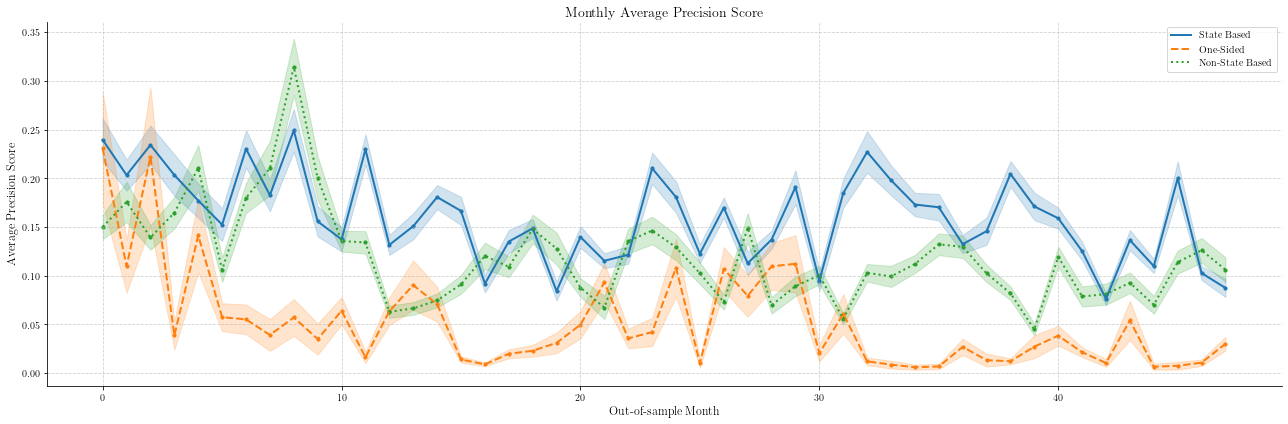

In [12]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(18, 6))  # Adjust the figure size as needed

# Data
x = df['monthly/out_sample_month']
y_state_based = df['monthly/average_precision_score0']
y_one_sided = df['monthly/average_precision_score1']
y_non_state_based = df['monthly/average_precision_score2']

y_state_based_std = df['monthly/average_precision_score_std0']
y_one_sided_std = df['monthly/average_precision_score_std1']
y_non_state_based_std = df['monthly/average_precision_score_std2']

# Plot the data with lines for each category
ax.plot(x, y_state_based, color='#1f77b4', linestyle='-', linewidth=2, label='State Based')
ax.plot(x, y_one_sided, color='#ff7f0e', linestyle='--', linewidth=2, label='One-Sided')
ax.plot(x, y_non_state_based, color='#2ca02c', linestyle=':', linewidth=2, label='Non-State Based')

# Shade the areas within 2x standard deviation
ax.fill_between(x, y_state_based - 2 * y_state_based_std, y_state_based + 2 * y_state_based_std, color='#1f77b4', alpha=0.2)
ax.fill_between(x, y_one_sided - 2 * y_one_sided_std, y_one_sided + 2 * y_one_sided_std, color='#ff7f0e', alpha=0.2)
ax.fill_between(x, y_non_state_based - 2 * y_non_state_based_std, y_non_state_based + 2 * y_non_state_based_std, color='#2ca02c', alpha=0.2)

# Adjust spines (removing the top and right spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set axis labels and title
ax.set_xlabel('Out-of-sample Month', fontsize=12)
ax.set_ylabel('Average Precision Score', fontsize=12)
ax.set_title('Monthly Average Precision Score', fontsize=14)

# Add a grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Customize tick labels
ax.tick_params(axis='both', which='both', labelsize=10)

# Add data points as dots
ax.scatter(x, y_state_based, color='#1f77b4', s=10, label='Data Points (State Based)')
ax.scatter(x, y_one_sided, color='#ff7f0e', s=10, label='Data Points (One-Sided)')
ax.scatter(x, y_non_state_based, color='#2ca02c', s=10, label='Data Points (Non-State Based)')

# Add text annotation
# Adjust annotation positions based on your data
#ax.annotate('Maximum (State Based)', xy=(x_max_state, y_max_state), xytext=(x_text, y_text),
#            arrowprops=dict(facecolor='black', arrowstyle='->'),
#            fontsize=10)

# Tighten the layout
plt.tight_layout()

# Save or display the plot
#plt.savefig('scientific_plot.png', dpi=300)
plt.show()


In [ ]:
   out_sample_month_list = [] # only used for pickle...
    ap_list = []
    mse_list = []
    auc_list = []
    brier_list = []

    for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

        y_score = mean_array[i].reshape(-1) # make it 1d  # nu 180x180
        y_score_prob = mean_class_array[i].reshape(-1) # nu 180x180

        # do not really know what to do with these yet.
        y_var = std_array[i].reshape(-1)  # nu 180x180
        y_var_prob = std_class_array[i].reshape(-1)  # nu 180x180

        y_true = out_of_sample_vol[:,i].reshape(-1)  # nu 180x180 . dim 0 is time
        y_true_binary = (y_true > 0) * 1


        mse = mean_squared_error(y_true, y_score)  # SHOULD THIS THEN ALSO BE SHRINKAGE OR SOMETHING???
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict = get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol, config)# so at least it gets reported sep.

        wandb.log(log_dict)


        out_sample_month_list.append(i) # only used for pickle...
        mse_list.append(mse)
        ap_list.append(ap) # add to list.
        auc_list.append(auc)
        brier_list.append(brier)

In [ ]:
np.array(posterior_list).shape

In [ ]:
test_vol.shape

In [ ]:
out_of_sample_vol.shape

In [ ]:
feature_number = 0 # sb just for testing

mean_class_pred = np.array(posterior_list_class[test_month]).mean(axis=0)[feature_number,:,:]
mean_pred = np.array(posterior_list[test_month]).mean(axis=0)[feature_number,:,:]
true_obs = out_of_sample_vol[:,test_month,:,:].squeeze()[feature_number,:,:]

In [ ]:
def get_posterior(model, views_vol, config, device, n):
    print('Testing initiated...')

    test_tensor = get_test_tensor(views_vol, config, device) # better cal thiis evel tensor

    out_of_sample_vol = test_tensor[:,-config.time_steps:,:,:,:].cpu().numpy() # not really a tensor now.. # 0 is TEMP HACK unitl real dynasim !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


    posterior_list = []
    posterior_list_class = []

    for i in range(n):
        pred_np_list, pred_class_np_list = test(model, test_tensor, config.time_steps, config, device) # --------------------------------------------------------------
        posterior_list.append(pred_np_list)
        posterior_list_class.append(pred_class_np_list)

        #if i % 10 == 0: # print steps 10
        print(f'Posterior sample: {i}/{n}', end = '\r')

    if config.sweep == False: # should ne in config...
        dump_location = '/home/projects/ku_00017/data/generated/conflictNet/'
        posterior_dict = {'posterior_list' : posterior_list, 'posterior_list_class': posterior_list_class, 'out_of_sample_vol' : out_of_sample_vol}
        with open(f'{dump_location}posterior_dict_{config.time_steps}_{config.run_type}.pkl', 'wb') as file:
            pickle.dump(posterior_dict, file)

        print("Posterior pickle dumped!")

    else:
        print('Running sweep. no posterior pickle dumped')

    # Get mean and std
    mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
    std_array = np.array(posterior_list).std(axis = 0)

    mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
    std_class_array = np.array(posterior_list_class).std(axis = 0)

    out_sample_month_list = [] # only used for pickle...
    ap_list = []
    mse_list = []
    auc_list = []
    brier_list = []

    for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

        y_score = mean_array[i].reshape(-1) # make it 1d  # nu 180x180
        y_score_prob = mean_class_array[i].reshape(-1) # nu 180x180

        # do not really know what to do with these yet.
        y_var = std_array[i].reshape(-1)  # nu 180x180
        y_var_prob = std_class_array[i].reshape(-1)  # nu 180x180

        y_true = out_of_sample_vol[:,i].reshape(-1)  # nu 180x180 . dim 0 is time
        y_true_binary = (y_true > 0) * 1


        mse = mean_squared_error(y_true, y_score)  # SHOULD THIS THEN ALSO BE SHRINKAGE OR SOMETHING???
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict = get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol, config)# so at least it gets reported sep.

        wandb.log(log_dict)


        out_sample_month_list.append(i) # only used for pickle...
        mse_list.append(mse)
        ap_list.append(ap) # add to list.
        auc_list.append(auc)
        brier_list.append(brier)

    if config.sweep == False:

    # DUMP
        metric_dict = {'out_sample_month_list' : out_sample_month_list, 'mse_list': mse_list,
                    'ap_list' : ap_list, 'auc_list': auc_list, 'brier_list' : brier_list}

        with open(f'{dump_location}metric_dict_{config.time_steps}_{config.run_type}.pkl', 'wb') as file:
            pickle.dump(metric_dict, file)

        with open(f'{dump_location}test_vol_{config.time_steps}_{config.run_type}.pkl', 'wb') as file: # make it numpy
            pickle.dump(test_tensor.cpu().numpy(), file)

        print('Metric and test pickle dumped!')

    else:
        print('Running sweep. no metric or test pickle dumped')

    # ------------------------------------------------------------------------------------
    wandb.log({f"{config.time_steps}month_mean_squared_error": np.mean(mse_list)})
    wandb.log({f"{config.time_steps}month_average_precision_score": np.mean(ap_list)})
    wandb.log({f"{config.time_steps}month_roc_auc_score": np.mean(auc_list)})
    wandb.log({f"{config.time_steps}month_brier_score_loss":np.mean(brier_list)})

In [ ]:
np.ma.masked_where((views_vol[-48,:,:,4] == 0), mean_pred)

In [ ]:
mean_class_pred[0,:,:].min()

In [ ]:
fig, axs = plt.subplots(2,3, )

# extent = (views_vol[:,:,:,1].min(), views_vol[:,:,:,1].max(), views_vol[:,:,:,2].min(), views_vol[:,:,:,2].max()) 
extent = (-25.75, 63.75, -46.75, 42.75)

fig.set_figheight(20)
fig.set_figwidth(30)

world.plot(ax = axs[0,0], color='none', edgecolor='black')
world.plot(ax = axs[0,1], color='none', edgecolor='black')
world.plot(ax = axs[0,2], color='none', edgecolor='black')
world.plot(ax = axs[1,0], color='none', edgecolor='black')
world.plot(ax = axs[1,1], color='none', edgecolor='black')
world.plot(ax = axs[1,2], color='none', edgecolor='black')

axs[0,0].imshow(mean_class_pred[0,:,:], extent = extent)
axs[0,1].imshow(mean_class_pred[1,:,:], extent = extent)
axs[0,2].imshow(mean_class_pred[2,:,:], extent = extent)
axs[1,0].imshow(mean_pred[0,:,:], extent = extent)
axs[1,1].imshow(mean_pred[1,:,:], extent = extent)
axs[1,2].imshow(mean_pred[2,:,:], extent = extent)

plt.show()

In [ ]:
# insert overall ap score.

def plt_trio(test_month, timelaps_dir, posterior_dict, feature_number):

    interpolation = 'none'

    # extent = (views_vol[:,:,:,1].min(), views_vol[:,:,:,1].max(), views_vol[:,:,:,2].min(), views_vol[:,:,:,2].max())
    extent = (-25.75, 63.75, -46.75, 42.75) # hardcode so you do not have to load views_vol

#    extent = (-100, 80, -100, 80) 


    posterior_list = posterior_dict['posterior_list']
    posterior_list_class = posterior_dict['posterior_list_class']
    out_of_sample_vol = posterior_dict['out_of_sample_vol']

    mean_class_pred = np.array(posterior_list_class[test_month]).mean(axis=0)[feature_number,:,:]
    mean_pred = np.array(posterior_list[test_month]).mean(axis=0)[feature_number,:,:]
    true_obs = out_of_sample_vol[:,test_month,:,:].squeeze()[feature_number,:,:]

    std_pred = np.array(posterior_list[test_month]).std(axis=0)[feature_number,:,:]

    # min/max for plotting
    min_true = out_of_sample_vol[:,0,:,:].min()
    max_true = out_of_sample_vol[:,0,:,:].max()
    min_pred = np.array(posterior_list).min()
    max_pred = np.array(posterior_list).max()
    min_pred_class = np.array(posterior_list_class).min()
    max_pres_class = np.array(posterior_list_class).max()

    min_pred_std = np.array(posterior_list).mean(axis=0).std(axis = 0).min()
    max_pred_std = np.array(posterior_list).mean(axis=0).std(axis = 0).max()

    all_abs_error = np.abs(out_of_sample_vol[:,0,:,:].squeeze() - np.array(posterior_list).mean(axis = 0))
    min_error = all_abs_error.min()
    max_error = all_abs_error.max()

    # abs error
    abs_error = np.abs(true_obs - mean_pred)


    # Confucsion
    threshold = 0.2 # there is a good way to do this... You have just forgotten it...

    binary_pred = (mean_class_pred > threshold) * 1 
    binary_true = (true_obs > 0)*1

    TP = ((binary_pred == 1) & (binary_true == 1)).astype('int')
    FP = ((binary_pred == 1) & (binary_true == 0)).astype('int')*2
    FN = ((binary_pred == 0) & (binary_true == 1)).astype('int')*3
    # TN = ((binary_pred == 0) & (binary_true == 0)).astype('int')*4


    confusion_map = TP + FP + FN #+ TN # TN per defualt 0

    # TN gray, TP green, FP blue, FN red
    colors = [ (0.5, 0.5, 0.5), (0, 1, 0), (0, 0, 1), (1, 0, 0)]  # R, G, B
    cmap_name = 'catagorical4'
    cat_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=4)

    # plot
    #plt.figure(figsize=[30,20])

    fig, axs = plt.subplots(2,3, sharey= True, sharex= True)
    
    fig.set_figheight(20)
    fig.set_figwidth(30)

    plt.subplots_adjust(wspace=-0.01, hspace=-0.2)

    axs[0,0].set_title(f'true, month {test_month}')
    true_obs_masked = true_obs # np.ma.masked_where((views_vol[-48,:,:,4] == 0), true_obs)
    world.plot(ax = axs[0,0], color='none', edgecolor='black')
    im = axs[0,0].imshow(true_obs_masked, cmap = 'rainbow', vmin= min_true, vmax=max_true, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[0,0], shrink = 0.6, label = 'observed magnitude y, i.e. log(best)')

    axs[0,1].set_title(f'pred, month {test_month}')
    mean_pred_masked = mean_pred # np.ma.masked_where((views_vol[-48,:,:,4] == 0), mean_pred)
    world.plot(ax = axs[0,1],color='none', edgecolor='black', figsize = [25,25])
    im = axs[0,1].imshow(mean_pred_masked, cmap = 'rainbow', vmin= min_pred, vmax=max_pred, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[0,1], shrink = 0.6, label = 'predictited magnitude, ŷ ')


    axs[0,2].set_title(f'pred class, month {test_month}')
    mean_class_pred_masked = mean_class_pred #np.ma.masked_where((views_vol[-48,:,:,4] == 0), mean_class_pred)
    world.plot(ax = axs[0,2],color='none', edgecolor='black', figsize = [25,25])
    im = axs[0,2].imshow(mean_class_pred_masked, cmap = 'rainbow', vmin= min_pred_class, vmax=max_pres_class, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[0,2], shrink = 0.6, label = 'predictited probability, ỹ')


    axs[1,0].set_title(f'absolute error, month {test_month}')
    abs_error_masked = abs_error # abs_error np.ma.masked_where((views_vol[-48,:,:,4] == 0), abs_error)
    world.plot(ax = axs[1,0],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,0].imshow(abs_error_masked, cmap = 'rainbow', vmin=min_error, vmax=max_error, aspect= 'equal', interpolation = interpolation, extent = extent) # min and max are not constant here!
    plt.colorbar(im, ax = axs[1,0], shrink = 0.6, label = 'absolute error, |y-ŷ|')


    axs[1,1].set_title(f'pred std, month {test_month}')  # wonrg title
    std_pred_masked = std_pred #np.ma.masked_where((views_vol[-48,:,:,4] == 0), std_pred)
    world.plot(ax = axs[1,1],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,1].imshow(std_pred_masked, cmap = 'rainbow', vmin=min_pred_std, vmax=max_pred_std, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[1,1], shrink = 0.6,  label = 'ensemble std (predicted magnitude, ŷ)')


    axs[1,2].set_title(f'confusion_map (T=0.2)pred std, month {test_month}')  # wonrg title
    confusion_map_masked = confusion_map # np.ma.masked_where((views_vol[-48,:,:,4] == 0), confusion_map)
    world.plot(ax = axs[1,2],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,2].imshow(confusion_map_masked, cmap = cat_cmap, vmin=0, vmax=3, aspect= 'equal', interpolation = interpolation, extent = extent)
    cbar = plt.colorbar(im, ax = axs[1,2], ticks = np.linspace(0.4,2.6,4), shrink = 0.6)
    cbar.set_ticklabels(['TN', 'TP', 'FP', 'FN'])

    #plt.subplots_adjust(hspace = -0.1, wspace = 0.1)

    fig_title = f'trio_{str(test_month).zfill(2)}'
    plt.savefig(timelaps_dir + str(feature_number) + '/' + fig_title + '.JPG', bbox_inches="tight")
    
    #plt.show()
    
    #plt.cla() # idk if this is also needed..
    #plt.clf() # idk if this is also needed..
    plt.close(fig) # so they do not display or take up mem
    #gc.collect()

In [ ]:
#plt_trio(0, timelaps_dir, posterior_dict, 0)

In [ ]:
#plt_trio(0, timelaps_dir, posterior_dict, 1)

In [ ]:
#plt_trio(0, timelaps_dir, posterior_dict, 2)

In [ ]:
for i in range(48):
    plt_trio(i, timelaps_dir, posterior_dict, 0)

In [ ]:
for i in range(48):
    plt_trio(i, timelaps_dir, posterior_dict, 1)

In [ ]:
for i in range(48):
    plt_trio(i, timelaps_dir, posterior_dict, 2)